# Fundamental matrices and epipolar lines search

The problem that we are observing here is one of the fundamental problems in computer vision. It could be viewed from the prospective of two-camera image observation and we will stop on two cameras for simplicity.


Let's consider two coplanar images (meaning that they create) a plane along with the observed object. 

![title](planar_images.png)

As we can see we have two observers, namely *O_1* and *O_2* and observer object *A*. Each of the observers has its own image and the observed object on those images is shown respectively as *A_1* and *A_2*.
The distance between the cameras is given as *t* and is considered constant between two images. 

The next useful thing to consider is the normal vectors to the O_1AO_2 plane. We could view this vector both from the camera 1 space or camera 2 space.

For camera one, namely *n_1 = t x A_1*. 

What is t? t is a matrix of cross product, we can get it when we will calculate the cross product of any two vectors and then apply it to dot product to some third vector.

Then we can also write *n_2 = Rn_1 = R(t x A_1) = R[tx]A_1*, where R is the rotation matrix of second camera relatively to the first camera.

![title](cross_product.png)

Also we need to introduce the temr of **Essential matrix E**. E is a 3x3 matrix which allows us to find the perpendicular vector regarding our camera point vectors.

- E has 6 degrees of freedom (rotation and translation).
- E is defined up to scaling by 5 point pairs
- E imposes restriction on coordinates in camera space.

![title](essential.png)

If we have pixel coordinates we need to use camera-callibration matrices.

![title](calib_pix.png)

And the fundamental matrix will then look:

![title](fundamental.png)

In [39]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [40]:
work_dir = os.getcwd()
print("Working directory %s" % work_dir)

Working directory /Users/olehmisko/Desktop/UCU docs/Computer-Vision-2019/computer-vision-hw/cv-4-0


In [41]:
data_dir = os.path.join(work_dir, 'data')
print("Data directory %s" % data_dir)

Data directory /Users/olehmisko/Desktop/UCU docs/Computer-Vision-2019/computer-vision-hw/cv-4-0/data


In [42]:
def get_img_path(img_name):
    return os.path.join(data_dir, img_name)

In [394]:
# Load the images 
# I omit first two images and show the results only for kind-of stereo pair
third_image = cv2.imread(get_img_path('ep_3.png'), 0)
fourth_image = cv2.imread(get_img_path('ep_4.png'), 0)

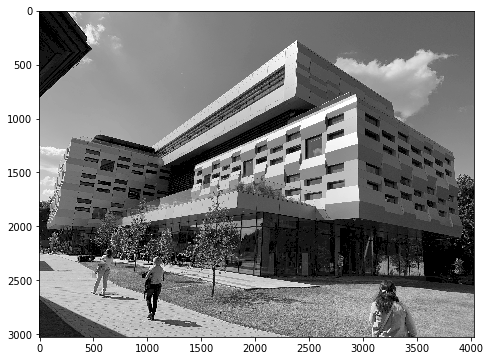

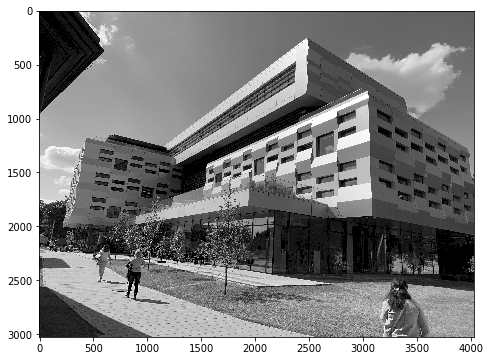

In [395]:
plt.figure(figsize=(8,6))
plt.imshow(third_image, cmap = 'gray')
plt.figure(figsize=(8,6))
plt.imshow(fourth_image, cmap = 'gray')

In [364]:
def normalize_for_8_point(a):
    """
    Performs a mean-std normalization for 8-point algorithm
    and returns normalized array and T for denormalization
    
    Input: 
    a - numpy array, array to be normalize
    
    Output:
    a_norm - numpy array, normalized copy of array 
    T - numpy array of shape (2, 3)
    """
    
    mu = np.mean(a, axis = 1)
    scale = np.sqrt(2) / np.std(a[:2])
    T = np.array( [ [scale, 0, -scale * mu[0]], \
                    [0, scale, -scale * mu[1]], \
                    [0, 0, 1]] )
    
    ones = np.ones(a.shape[0], dtype = np.int32)
    
    a = np.hstack((a, np.atleast_2d(ones).T))
        
    newpts = np.dot(T, a.T)

    return (newpts, T)


def compute_fundamental_matrix(p1, p2, n = 8):
    """
    Computes the fundamental matrix from two
    arrays of corresponding points. 
    Inspired by MATLAB implementation of 8-point normalized algorithm.
    Points in matrix A are constructed by the next algorithm:
    [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1]
    
    Input:
    p1, p2 - numpy arrays of shape [2,n], contain points of interest
    
    Output:
    F - numpy matrix, fundamental matrix for two images
    
    NOTE: In this algorithm we compute fundamental, not elementary matrix!
    """
    
    # Normalize points
    p1_norm, T1 = normalize_for_8_point(p1)
    p2_norm, T2 = normalize_for_8_point(p2)
        
    # Create empty matrix for equations
    A = np.zeros((n, 9))
    
    # Fill in the equation matrix 
    for i in range(n):
        A[i] = [ p1_norm[0, i] * p2_norm[0, i],  p1_norm[0, i] * p2_norm[1, i],  1, \
                 p1_norm[1, i] * p2_norm[0, i],  p1_norm[1, i] * p2_norm[1, i], 1, \
                 p1_norm[2, i] * p2_norm[0, i],  p1_norm[2, i] * p2_norm[1, i], 1 ]
        
    # Perform SVD
    U, S, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)
    
    # Force F to be rank 2 matrix
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))
    F = F / F[2, 2]
    
    # Denormalize F using first points
    
    F = np.dot(T1, np.dot(F, T2.T))
    
    return F

In [377]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines 
        Copyright: OpenCV
        '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 3)
        img1 = cv2.circle(img1, tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [378]:
# Initialize points for images
# Points are handcrafted by hand

ep3 = [[2953,1229], [2654,1321], [2643,1428], \
       [2415,1485], [2404,1393], [2272,1435], \
       [2265,1521], [2094,1489]]

ep4 = [[3067,1207], [2760,1300], [2753,1403], \
       [2518,1460], [2515,1371], [2372,1418], \
       [2372,1500], [2194,1471]]

ep3 = np.asarray(ep2)
ep4 = np.asarray(ep3)

In [391]:
# Compute fundamental matrice for points from second and third image by custom method
F = compute_fundamental_matrix(ep3, ep4)

# Compute epipolar lines
# Add ones to the points
ones = np.ones(ep2.shape[0], dtype = np.int32)
    
ep2_copy = np.hstack((ep2, np.atleast_2d(ones).T))
ep3_copy = np.hstack((ep3, np.atleast_2d(ones).T))

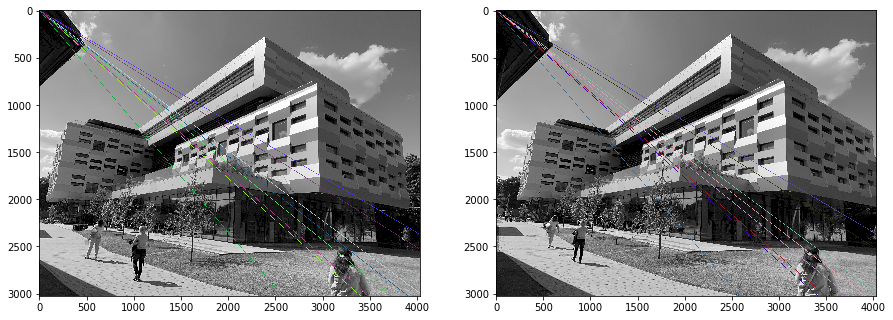

In [393]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(third_image, fourth_image, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(fourth_image, third_image, lines2, pts2, pts1)


f, axs = plt.subplots(2,2,figsize=(15,15))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

We see that the implementation works pretty well and finds the corresponding epipolar lines. The drawing logic and epipolar lines from points and fundamental matrix was taken from [OpenCV Epipolar Geometry Post](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html) as well as some inspiration for the task overall.
The logic for fundamental matrix computation was taken directly from the [lecture slides](https://drive.google.com/file/d/1pwLQiEEJ6jpT0uzsYU_kwkwk6vyPTP5k/view) and the logic of 2dpoints normalization was taken and rewritten from [Smotko repository snippet](https://github.com/Smotko/computer-vision-class/blob/master/vaja5/normalize2dpts.m)